In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_image(path):
    im = Image.open(path).convert('L')
    im = im.resize((32,32))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        plt.imshow(img , cmap='gray') 

        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y1_list = []
    y2_list = []
    # label_dict = cfw_dict
    for folder in sorted(os.listdir(dir_path)):
        if(folder[0] == folder[1]):
            continue

        directory = os.path.join(dir_path,folder)
        for filename in os.listdir(directory):
            if filename.endswith(".png"):
                im = load_image(os.path.join(directory,filename))
                # print(filename)
                y = filename.split('_')[1]
                # print(y)
                image_list.append(im)
                # print(int(y[0]), int(y[1]))
                y1_list.append(int(y[0]))
                y2_list.append(int(y[1]))
            else:
                continue
    
    y_list = np.concatenate(np.array(y1_list), np.array(y2_list))
    return image_list, y_list

In [25]:
### Implement and train an MLP model on the MultiMNIST dataset

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Set a random seed for reproducibility
torch.manual_seed(0)

# Define data transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/train", transform=transform)
test_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/test", transform=transform)
val_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/val", transform=transform)

# take only 10% of the dataset
train_dataset = torch.utils.data.Subset(train_dataset, range(0, int(len(train_dataset)*0.1)))
test_dataset = torch.utils.data.Subset(test_dataset, range(0, int(len(test_dataset)*0.1)))
val_dataset = torch.utils.data.Subset(val_dataset, range(0, int(len(val_dataset)*0.1)))
# print(type(train_dataset))

# # remove the images from dataset having class same digit twice
# train_dataset = [(image, label) for image, label in train_dataset.samples if train_dataset.classes[label][0] != train_dataset.classes[label][1]]
# test_dataset = [(image, label) for image, label in test_dataset.samples if test_dataset.classes[label][0] != test_dataset.classes[label][1]]
# val_dataset = [(image, label) for image, label in val_dataset.samples if val_dataset.classes[label][0] != val_dataset.classes[label][1]]


# # convert a list of tuples to torchvision.datasets.folder.ImageFolder of tuples
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
# ])

# train_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/train", transform=transform, loader=lambda x: train_dataset[x][0], target_transform=lambda x: train_dataset[x][1])
# test_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/test", transform=transform, loader=lambda x: test_dataset[x][0], target_transform=lambda x: test_dataset[x][1])
# val_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/val", transform=transform, loader=lambda x: val_dataset[x][0], target_transform=lambda x: val_dataset[x][1])

# print(type(train_dataset))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)





In [26]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_hidden_layers):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
        
        x = self.fc2(x)
        return x
# Set hyperparameters
input_size = 64*64
hidden_size = 128
num_classes = 100 # 100 classes (digits 0-99)
num_hidden_layers = 2

learning_rate = 0.001
batch_size = 64
num_epochs = 5


# Initialize the model and optimizer
model = MLP(input_size, hidden_size, num_classes, num_hidden_layers)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# Evaluation on the test set


Epoch [1/5], Loss: 1.5397
Epoch [2/5], Loss: 1.4159
Epoch [3/5], Loss: 1.1450
Epoch [4/5], Loss: 0.9647
Epoch [5/5], Loss: 0.8528


#### Evaluation

In [27]:
model.eval()
# # Evaluation on the Train set
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in train_loader:
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         labels_np = labels.numpy()
#         predicted_np = predicted.numpy()

#         for i in range(len(labels_np)):
#             if 

#     accuracy = 100 * correct / total
#     print(f'Train set Accuracy: {accuracy}%')

# Evaluation on the validation set
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        labels_np = labels.numpy()
        predicted_np = predicted.numpy()

        # Check if the last digit matches
        last_digit_match = np.mod(labels_np, 10) == np.mod(predicted_np, 10)
        correct += np.count_nonzero(last_digit_match)

        # Check if both labels and predictions have more than one digit and their second digits match
        both_digits_match = (labels_np > 9) & (predicted_np > 9) & (labels_np // 10 == predicted_np // 10)
        correct += np.count_nonzero(both_digits_match)
        
    accuracy = 100 * correct / total
    print(f'Val set Accuracy: {accuracy}%')

# Evaluation on the Test set
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        labels_np = labels.numpy()
        predicted_np = predicted.numpy()

        # Check if the last digit matches
        last_digit_match = np.mod(labels_np, 10) == np.mod(predicted_np, 10)
        correct += np.count_nonzero(last_digit_match)

        # Check if both labels and predictions have more than one digit and their second digits match
        both_digits_match = (labels_np > 9) & (predicted_np > 9) & (labels_np // 10 == predicted_np // 10)
        correct += np.count_nonzero(both_digits_match)

    accuracy = 100 * correct / total
    print(f'Test set Accuracy: {accuracy}%')


Val set Accuracy: 10.8125%
Test set Accuracy: 15.6%


#### Hyperparameter Tuning: Adjust the number of hidden layers and the number of neurons within each layer to optimize performance and find the best model.

In [28]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [29]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [30]:
wandb.init(
    project="MLP-Double-MNIST",
)

In [31]:
# Initialize Weights & Biases Sweep
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'MLP-Double-MNIST_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {
        'hidden_layer_sizes':{'values': [1, 2, 3]},
        'neurons_per_layer': {'values': [64,128, 256]},
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="MLP-Double-MNIST")

Create sweep with ID: izadk7g9
Sweep URL: https://wandb.ai/guptayatharth1/MLP-Double-MNIST/sweeps/izadk7g9


In [32]:
# import itertools

# # Define the hyperparameter search space
# hidden_layer_sizes = [1, 2, 3]  # Number of hidden layers
# neurons_per_layer = [64, 128, 256]  # Number of neurons in each layer

# best_model = None
# best_accuracy = 0.0

# # Grid search through the hyperparameter space
# for num_layers, num_neurons in itertools.product(hidden_layer_sizes, neurons_per_layer):
#     # Define and train the model with the current hyperparameters
#     model = MLP(input_size, num_neurons, num_classes)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = nn.CrossEntropyLoss()
#     ##################

#     # train
#     num_epochs = 10
#     for epoch in range(num_epochs):
#         model.train()
#         for images, labels in train_loader:
#             optimizer.zero_grad()

#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             loss.backward()
#             optimizer.step()

#         print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()}')

#     # Evaluation on the validation set
#     model.eval()
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in val_loader:
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         accuracy = 100 * correct / total
#         print(f'Validation Accuracy: {accuracy}%')
#     ############
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model = model

# print(f"Best Accuracy: {best_accuracy}%")


def train():
    # Initialize Weights & Biases run
    with wandb.init() as run:
        config = run.config

        # Initialize the model and optimizer
        model = MLP(input_size, config.neurons_per_layer, num_classes, config.hidden_layer_sizes)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        num_epochs = 10
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # Evaluation on the validation set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                labels_np = labels.numpy()
                predicted_np = predicted.numpy()

                # Check if the last digit matches
                last_digit_match = np.mod(labels_np, 10) == np.mod(predicted_np, 10)
                correct += np.count_nonzero(last_digit_match)

                # Check if both labels and predictions have more than one digit and their second digits match
                both_digits_match = (labels_np > 9) & (predicted_np > 9) & (labels_np // 10 == predicted_np // 10)
                correct += np.count_nonzero(both_digits_match)

            accuracy = 100 * correct / total
            wandb.log({'val_accuracy': accuracy})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: xs7rurw7 with config:
wandb: 	hidden_layer_sizes: 1
wandb: 	neurons_per_layer: 64


val_accuracy,▁
val_accuracy,12.9375


wandb: Agent Starting Run: ujtl1w77 with config:
wandb: 	hidden_layer_sizes: 1
wandb: 	neurons_per_layer: 128


val_accuracy,▁
val_accuracy,10.875


wandb: Agent Starting Run: hj6u4kkb with config:
wandb: 	hidden_layer_sizes: 1
wandb: 	neurons_per_layer: 256


val_accuracy,▁
val_accuracy,10.5


wandb: Agent Starting Run: r2pkmkhf with config:
wandb: 	hidden_layer_sizes: 2
wandb: 	neurons_per_layer: 64


val_accuracy,▁
val_accuracy,13.1875


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fwmpgf4e with config:
wandb: 	hidden_layer_sizes: 2
wandb: 	neurons_per_layer: 128


val_accuracy,▁
val_accuracy,11.3125


wandb: Agent Starting Run: n3yhi804 with config:
wandb: 	hidden_layer_sizes: 2
wandb: 	neurons_per_layer: 256


val_accuracy,▁
val_accuracy,13.8125


wandb: Agent Starting Run: lxlf9qxm with config:
wandb: 	hidden_layer_sizes: 3
wandb: 	neurons_per_layer: 64


val_accuracy,▁
val_accuracy,7.9375


wandb: Agent Starting Run: dtt8k078 with config:
wandb: 	hidden_layer_sizes: 3
wandb: 	neurons_per_layer: 128


val_accuracy,▁
val_accuracy,8.8125


wandb: Agent Starting Run: fixzl9mx with config:
wandb: 	hidden_layer_sizes: 3
wandb: 	neurons_per_layer: 256


val_accuracy,▁
val_accuracy,7.125


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f6bf8de0790>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

#### CNN FOR THE MULTI -DIGIT DATASET

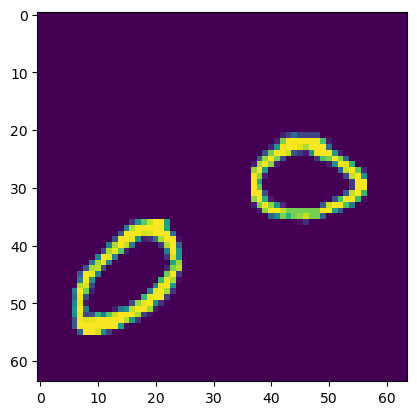

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
# Set a random seed for reproducibility
torch.manual_seed(0)

# # Define data transforms# Define data transforms
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),  # Resize to 64x64 pixels
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3 color channels
# ])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load datasets using ImageFolder
train_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/train", transform=transform)
train_class_to_idx = train_dataset.class_to_idx
test_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/test", transform=transform)
test_class_to_idx = test_dataset.class_to_idx
val_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/val", transform=transform)
val_class_to_idx = val_dataset.class_to_idx

# take only 30% of the dataset
train_dataset = torch.utils.data.Subset(train_dataset, range(0, int(len(train_dataset)*0.3)))
test_dataset = torch.utils.data.Subset(test_dataset, range(0, int(len(test_dataset)*0.3)))
val_dataset = torch.utils.data.Subset(val_dataset, range(0, int(len(val_dataset)*0.3)))

# Manually set the class_to_idx attribute for test_dataset and val_dataset
# test_dataset.class_to_idx = class_to_idx_mapping
# val_dataset.class_to_idx = class_to_idx_mapping
# print(train_dataset.find_classes("./double_mnist_seed_123_image_size_64_64/train"))
plt.imshow(train_dataset[0][0][0])
# print(type(train_dataset))

# # remove the images from dataset having class same digit twice
# train_dataset = [(image, label) for image, label in train_dataset.samples if train_dataset.classes[label][0] != train_dataset.classes[label][1]]
# test_dataset = [(image, label) for image, label in test_dataset.samples if test_dataset.classes[label][0] != test_dataset.classes[label][1]]
# val_dataset = [(image, label) for image, label in val_dataset.samples if val_dataset.classes[label][0] != val_dataset.classes[label][1]]


# # convert a list of tuples to torchvision.datasets.folder.ImageFolder of tuples
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
# ])

# train_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/train", transform=transform, loader=lambda x: train_dataset[x][0], target_transform=lambda x: train_dataset[x][1])
# test_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/test", transform=transform, loader=lambda x: test_dataset[x][0], target_transform=lambda x: test_dataset[x][1])
# val_dataset = ImageFolder(root="./double_mnist_seed_123_image_size_64_64/val", transform=transform, loader=lambda x: val_dataset[x][0], target_transform=lambda x: val_dataset[x][1])

# print(type(train_dataset))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

val_idx_to_class = {v: k for k, v in val_class_to_idx.items()}
test_idx_to_class = {v: k for k, v in test_class_to_idx.items()}
train_idx_to_class = {v: k for k, v in train_class_to_idx.items()}

In [10]:
# Define the CNN model for input images of size 64x64 with grayscale channels in a batch of 64 and 100 classes
# class CNN(nn.Module):
#     def __init__(self, num_classes,ker_size=3, dropout=0.5):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=ker_size, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=ker_size, stride=1, padding=1)
#         self.fc1 = nn.Linear(32 * 16 * 16, 128)
#         self.fc2 = nn.Linear(128, num_classes)
#         self.relu = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(dropout)


#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.pool(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

class CNN(nn.Module):
    def __init__(self, num_classes, ker_size=3, dropout=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=ker_size, stride=1, padding=ker_size // 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=ker_size, stride=1, padding=ker_size // 2)
        
        # Calculate the input size for the fully connected layer
        self.fc_input_size = self.calculate_fc_input_size(ker_size)
        
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)

    def calculate_fc_input_size(self, ker_size):
        # Define a dummy input tensor to calculate the output size after convolution and pooling
        dummy_input = torch.ones(1, 1, 64, 64)  # Assuming 64x64 input image size
        x = self.conv1(dummy_input)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x.size(1) * x.size(2) * x.size(3)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set hyperparameters
learning_rate = 0.001
num_classes = 100  

# # Initialize the CNN model and optimizer
# model = CNN(num_classes,3,0.1)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     for images, labels in train_loader:
#         # print(labels.shape)
#         optimizer.zero_grad()
#         outputs = model(images)
#         # print(outputs.shape)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()}')



05
3
03
0


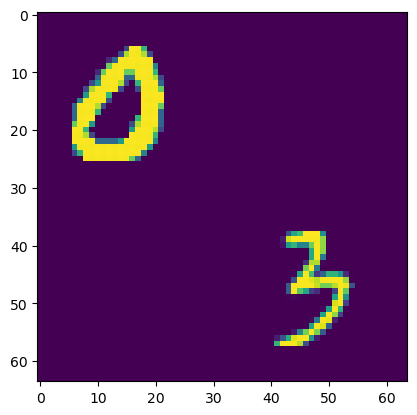

In [11]:
i=0
for (images, labels) in val_loader:
        if(i == 1):
                plt.imshow(images[0][0])
                outputs = model(images[0:1])
                _, predicted = torch.max(outputs.data, 1) 
                print(train_idx_to_class[predicted[0].item()])
                print(predicted[0].item())
                print(val_idx_to_class[labels[0].item()])
                print(labels[0].item())
                if(train_idx_to_class[predicted[0].item()] == val_idx_to_class[labels[0].item()]):
                        print("correct")
                break
        i+=1
# plt.imshow(val_loader.dataset[1000][0][0])
# outputs = model(val_loader.dataset[1000][0][0:1])
# _, predicted = torch.max(outputs.data, 1) 
# print(train_idx_to_class[predicted[0].item()])
# print(predicted[0].item())
# print(val_idx_to_class[labels[0].item()])
# print(labels[0].item())
# if(train_idx_to_class[predicted[0].item()] == val_idx_to_class[labels[0].item()]):
#         print("correct")
# # break




In [12]:
import numpy as np  
# Evaluation on the validation set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range(len(labels)):
            pred = int(train_idx_to_class[predicted[i].item()])
            label = int(val_idx_to_class[labels[i].item()])
            if(pred%10 == label%10 or pred//10 == label//10):
                correct += 1
        

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy}%')

# # Evaluation on the train set
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in train_loader:
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         labels_np = labels.numpy()
#         predicted_np = predicted.numpy()

#         # Check if the last digit matches
#         last_digit_match = np.mod(labels_np, 10) == np.mod(predicted_np, 10)
#         correct += np.count_nonzero(last_digit_match)

#         # Check if both labels and predictions have more than one digit and their second digits match
#         both_digits_match = (labels_np > 9) & (predicted_np > 9) & (labels_np // 10 == predicted_np // 10)
#         correct += np.count_nonzero(both_digits_match)
        

    # accuracy = 100 * correct / total
    # print(f'Train Accuracy: {accuracy}%')

# Evaluation on the train set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range(len(labels)):
            pred = int(train_idx_to_class[predicted[i].item()])
            label = int(test_idx_to_class[labels[i].item()])
            if(pred%10 == label%10 or pred//10 == label//10):
                correct += 1
        

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')

Validation Accuracy: 100.0%
Test Accuracy: 50.0%


#### Hyperparameter Tuning: Experiment with different learning rates, kernel sizes, and dropout rates to determine the optimal configuration

In [16]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [17]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(
    project="CNN-Double-MNIST",
)

In [18]:
# Initialize Weights & Biases Sweep
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'CNN-Double-MNIST_sweep2',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {
        'learning_rate':{'values': [0.001, 0.01, 0.1]},
        'dropout': {'values': [0.0, 0.1, 0.2]},
        'kernel_size': {'values': [3,5]},
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="CNN-Double-MNIST")

Create sweep with ID: 5glxcequ
Sweep URL: https://wandb.ai/guptayatharth1/CNN-Double-MNIST/sweeps/5glxcequ


In [19]:


def train():
    # Initialize Weights & Biases run
    with wandb.init() as run:
        config = run.config

        # Define the model with the current hyperparameters
        model = CNN(num_classes,config.kernel_size, config.dropout)
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluation on the validation set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                for i in range(len(labels)):
                    pred = int(train_idx_to_class[predicted[i].item()])
                    label = int(val_idx_to_class[labels[i].item()])
                    if(pred%10 == label%10 or pred//10 == label//10):
                        correct += 1

            accuracy = 100 * correct / total
            wandb.log({'val_accuracy': accuracy})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()



# # Define lists of hyperparameters to search over
# learning_rates = [0.1, 0.01, 0.001]
# kernel_sizes = [(3, 3), (5, 5)]
# dropout_rates = [0.0, 0.2, 0.5]

# best_accuracy = 0.0
# best_hyperparameters = {}

# for lr in learning_rates:
#     for kernel_size in kernel_sizes:
#         for dropout_rate in dropout_rates:
            # # Define the model with the current hyperparameters
            # model = CNN(num_classes, kernel_size=kernel_size, dropout_rate=dropout_rate)
            # optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # # Training loop
            # num_epochs = 10
            # for epoch in range(num_epochs):
            #     model.train()
            #     for images, labels in train_loader:
            #         optimizer.zero_grad()
            #         outputs = model(images)
            #         loss = criterion(outputs, labels)
            #         loss.backward()
            #         optimizer.step()
            
#             # Evaluation on the validation set
#             model.eval()
#             with torch.no_grad():
#                 correct = 0
#                 total = 0
#                 for images, labels in val_loader:
#                     outputs = model(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()
#                 accuracy = 100 * correct / total
            
#             print(f'Learning Rate: {lr}, Kernel Size: {kernel_size}, Dropout Rate: {dropout_rate}, Validation Accuracy: {accuracy}%')
            
#             # Update the best hyperparameters if a better configuration is found
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_hyperparameters = {
#                     'learning_rate': lr,
#                     'kernel_size': kernel_size,
#                     'dropout_rate': dropout_rate
#                 }

# print(f'Best Hyperparameters: {best_hyperparameters}, Best Validation Accuracy: {best_accuracy}%')


wandb: Agent Starting Run: 7anxqywa with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Exception in thread Thread-6 (_run_job):
Traceback (most recent call last):
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_95980/4195188175.py", line 3, in train
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 3280, in __exit__
    self._finish(exit_code=exit_code)
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 1966, in _finish
    hook.call()
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 447, in _jupyter_teardown
    self.notebook.save_history()
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/jupyter.py", line 435, in save_history
    from nbformat import v4, validator, write
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/nbformat/__init__.py", line 11, in <module>
    from . import v1, v2, v3,

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: 1zc06u0v with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,97.0


wandb: Agent Starting Run: 6deg5hnw with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,37.5


wandb: Agent Starting Run: 3h67ax6f with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,97.77083


wandb: Agent Starting Run: ld5iv9n4 with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,95.22917


wandb: Agent Starting Run: dso75ih8 with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,41.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g7a03n7h with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,97.625


wandb: Agent Starting Run: ca694cq6 with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,94.60417


wandb: Agent Starting Run: ajs5ui6h with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,41.66667


wandb: Agent Starting Run: 9nsvcwop with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,97.1875


wandb: Agent Starting Run: jjkcdm6n with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,96.8125


wandb: Agent Starting Run: 4o78a47u with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,58.33333


wandb: Agent Starting Run: ddknf2e8 with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,97.875


wandb: Agent Starting Run: bmorx5x6 with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,97.08333


wandb: Agent Starting Run: 5gwmqmox with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,20.83333


wandb: Agent Starting Run: 6l6o4shw with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,98.54167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 819cmzs0 with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,97.45833


wandb: Agent Starting Run: i5ktdqkk with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,41.66667


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7feb55e5bb80>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

#### Testing on Single digit MNIST

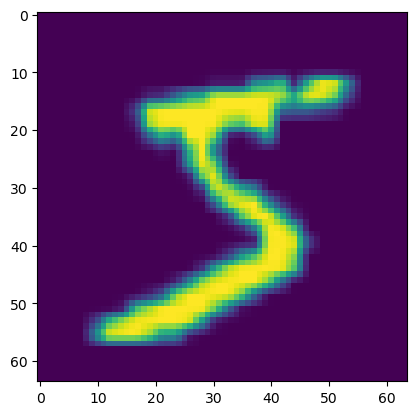

In [18]:
from torchvision.datasets import MNIST
from torchvision import transforms
from matplotlib import pyplot as plt    

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load the MNIST dataset
mnist_dataset = MNIST(root='./mnist_dataset', train=True, download=True, transform=transform)

# Create a DataLoader for the MNIST dataset
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=False)

plt.imshow(mnist_dataset[0][0][0])


In [19]:
# train the double mnist model on best hyperparameters
model = CNN(num_classes,5,0.2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        # print(labels.shape)
        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()}')


Epoch [1/10] - Loss: 0.6279054284095764
Epoch [2/10] - Loss: 0.4332427382469177
Epoch [3/10] - Loss: 0.23735328018665314
Epoch [4/10] - Loss: 0.07654328644275665
Epoch [5/10] - Loss: 0.20686060190200806
Epoch [6/10] - Loss: 0.04224998876452446
Epoch [7/10] - Loss: 0.04682101309299469
Epoch [8/10] - Loss: 0.026888370513916016
Epoch [9/10] - Loss: 0.040468860417604446
Epoch [10/10] - Loss: 0.02108345553278923


In [27]:
# Assuming you have already trained the CNN model and it's stored in the 'model' variable
model.eval()

# Evaluation on the MNIST dataset
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in mnist_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on MNIST Single-Digit Images: {accuracy:.2f}%')

Accuracy on MNIST Single-Digit Images: 6.30%


## Permuted MNIST

[0 1 2 3 4 5 6 7 8 9]


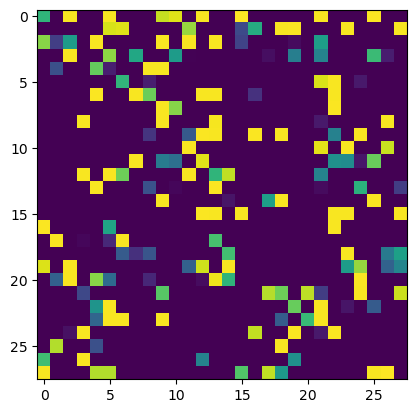

In [28]:
# To load the dataset
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

x_train = np.load("permuted_mnist/train_images.npy")
y_train = np.load("permuted_mnist/train_labels.npy")
x_test = np.load("permuted_mnist/test_images.npy")
y_test = np.load("permuted_mnist/test_labels.npy")

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
plt.imshow(x_train[0])

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.long).clone().detach()

x_val = torch.tensor(x_val, dtype=torch.float).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.long).clone().detach()

x_test = torch.tensor(x_test, dtype=torch.float).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.long).clone().detach()

# print(x_train.shape)
# print(y_train.shape)


# print(x_test.shape)
# print(y_test.shape)
# Create DataLoader for training and validation data
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

## MLP on Permuted-MNIST

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_hidden_layers):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
        
        x = self.fc2(x)
        return x

# Initialize the model and optimizer
model = MLP(784, 128, 10, 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Evaluate the model on the test set
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')



Epoch 1/10, Validation Loss: 66.8056, Validation Accuracy: 94.64%
Epoch 2/10, Validation Loss: 61.0900, Validation Accuracy: 95.64%
Epoch 3/10, Validation Loss: 60.2143, Validation Accuracy: 95.67%
Epoch 4/10, Validation Loss: 61.0808, Validation Accuracy: 95.88%
Epoch 5/10, Validation Loss: 51.1628, Validation Accuracy: 96.74%
Epoch 6/10, Validation Loss: 59.7018, Validation Accuracy: 96.51%
Epoch 7/10, Validation Loss: 52.8556, Validation Accuracy: 96.76%
Epoch 8/10, Validation Loss: 69.3004, Validation Accuracy: 96.22%
Epoch 9/10, Validation Loss: 57.4950, Validation Accuracy: 96.78%
Epoch 10/10, Validation Loss: 72.5420, Validation Accuracy: 96.52%
Test Loss: 57.5060, Test Accuracy: 96.70%


In [35]:
# Evaluate the model on the val set
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * correct / total
print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.2f}%')

Val Loss: 72.5420, Val Accuracy: 96.52%


In [36]:
# Evaluate the model on the train set
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * correct / total
print(f'Train Loss: {test_loss:.4f}, Train Accuracy: {test_accuracy:.2f}%')

Train Loss: 111.0514, Train Accuracy: 98.19%


### Hyperparameter Tuning: Adjust the number of hidden layers and the number of neurons within each layer to optimize performance and find the best model.

In [37]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [38]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [39]:
wandb.init(
    project="MLP-permuted-MNIST",
)

In [40]:
# Initialize Weights & Biases Sweep
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'MLP-permuted-MNIST_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {
        'hidden_layer_sizes':{'values': [1, 2, 3]},
        'neurons_per_layer': {'values': [64,128, 256]},
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="MLP-permuted-MNIST")

Create sweep with ID: 23red48u
Sweep URL: https://wandb.ai/guptayatharth1/MLP-permuted-MNIST/sweeps/23red48u


In [41]:
def train():
    # Initialize Weights & Biases run
    with wandb.init() as run:
        config = run.config

        # Initialize the model and optimizer
        model = MLP(784, config.neurons_per_layer, 10, config.hidden_layer_sizes)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 10

        for epoch in range(num_epochs):
            model.train()
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            correct = 0
            total = 0
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        val_accuracy = 100 * correct / total
        wandb.log({'val_accuracy': val_accuracy})
    
# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: ckx3v9nd with config:
wandb: 	hidden_layer_sizes: 1
wandb: 	neurons_per_layer: 64


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    Exception in thread self.run()NetStatThr
Exception in thread :
  File "/usr/lib/python3.10/threading.py", line 953, in run
IntMsgThrTraceback (most recent call last):
:
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    Traceback (most recent call last):
self._target(*self._args, **self._kwargs)  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    
    self.run()  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 286, in check_stop_status
self.run()

      File "/usr/lib/python3.10/threading.py", line 953, in run
  File "/usr/lib/python3.10/threading.py", line 953, in run
self._loop_check_status(    
self._target(*self._args, **self._kwargs)  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 224, in _loop_che

val_accuracy,▁
val_accuracy,95.73333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: obf3ld90 with config:
wandb: 	hidden_layer_sizes: 1
wandb: 	neurons_per_layer: 128


val_accuracy,▁
val_accuracy,96.475


wandb: Agent Starting Run: yand5nn3 with config:
wandb: 	hidden_layer_sizes: 1
wandb: 	neurons_per_layer: 256


val_accuracy,▁
val_accuracy,96.94167


wandb: Agent Starting Run: n4otsbgj with config:
wandb: 	hidden_layer_sizes: 2
wandb: 	neurons_per_layer: 64


val_accuracy,▁
val_accuracy,96.19167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 42srm5ql with config:
wandb: 	hidden_layer_sizes: 2
wandb: 	neurons_per_layer: 128


val_accuracy,▁
val_accuracy,96.725


wandb: Agent Starting Run: uwzzldrh with config:
wandb: 	hidden_layer_sizes: 2
wandb: 	neurons_per_layer: 256


val_accuracy,▁
val_accuracy,96.84167


wandb: Agent Starting Run: m8ejeips with config:
wandb: 	hidden_layer_sizes: 3
wandb: 	neurons_per_layer: 64


val_accuracy,▁
val_accuracy,96.875


wandb: Agent Starting Run: 6h1x1c0i with config:
wandb: 	hidden_layer_sizes: 3
wandb: 	neurons_per_layer: 128


val_accuracy,▁
val_accuracy,96.65


wandb: Agent Starting Run: rm7lu2fl with config:
wandb: 	hidden_layer_sizes: 3
wandb: 	neurons_per_layer: 256


val_accuracy,▁
val_accuracy,97.11667


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f4ff9ac2350>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

## CNN on Permuted-MNIST

Epoch 1/10, Validation Loss: 54.2980, Validation Accuracy: 90.85%
Epoch 2/10, Validation Loss: 49.0723, Validation Accuracy: 91.65%
Epoch 3/10, Validation Loss: 44.3140, Validation Accuracy: 92.52%
Epoch 4/10, Validation Loss: 46.0725, Validation Accuracy: 93.47%
Epoch 5/10, Validation Loss: 46.4623, Validation Accuracy: 92.92%
Epoch 6/10, Validation Loss: 53.2757, Validation Accuracy: 92.43%
Epoch 7/10, Validation Loss: 50.7980, Validation Accuracy: 93.28%
Epoch 8/10, Validation Loss: 58.3603, Validation Accuracy: 93.18%
Epoch 9/10, Validation Loss: 59.0542, Validation Accuracy: 93.67%
Epoch 10/10, Validation Loss: 57.0910, Validation Accuracy: 93.85%


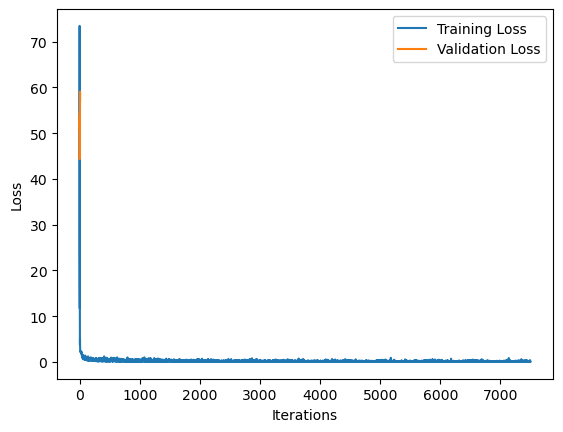

Test Loss: 101.2431, Test Accuracy: 93.76%


In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Load your data (x_train, y_train, x_val, y_val, x_test, y_test)
x_train = np.load("permuted_mnist/train_images.npy")
y_train = np.load("permuted_mnist/train_labels.npy")
x_test = np.load("permuted_mnist/test_images.npy")
y_test = np.load("permuted_mnist/test_labels.npy")

# use 50 percent of the training data
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.5)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.long).clone().detach()

x_val = torch.tensor(x_val, dtype=torch.float).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.long).clone().detach()

x_test = torch.tensor(x_test, dtype=torch.float).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.long).clone().detach()


# Create DataLoader for training and validation data
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Initialize the model and optimizer
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x.unsqueeze(1))  # Add a channel dimension
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x.unsqueeze(1))  # Add a channel dimension
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        val_losses.append(val_loss)

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x.unsqueeze(1))  # Add a channel dimension
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


#### Train and validation set accuracy

In [2]:
# Evaluate the model on the Train set
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x.unsqueeze(1))  # Add a channel dimension
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * correct / total
print(f'Train Loss: {test_loss:.4f}, Train Accuracy: {test_accuracy:.2f}%')


# Evaluate the model on the test set
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)
model.eval()
with torch.no_grad():
    val_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x.unsqueeze(1))  # Add a channel dimension
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * correct / total
print(f'Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%')

Train Loss: 37.1300, Train Accuracy: 98.43%
Validation Loss: 109.6283, Validation Accuracy: 92.93%


#### Hyperparameter Tuning: Experiment with different learning rates, kernel sizes, and dropout rates to determine the optimal configuration.

In [2]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [4]:
wandb.init(
    project="CNN-permuted-MNIST",
)

In [5]:
# Initialize Weights & Biases Sweep
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'CNN-permuted-MNIST_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {
        'learning_rate':{'values': [0.001, 0.01, 0.1]},
        'dropout': {'values': [0.0, 0.1, 0.2]},
        'kernel_size': {'values': [3,5]},
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="CNN-permuted-MNIST")

Create sweep with ID: i3yqhd6x
Sweep URL: https://wandb.ai/guptayatharth1/CNN-permuted-MNIST/sweeps/i3yqhd6x


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, num_classes=10, ker_size=3, dropout=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=ker_size, stride=1, padding=ker_size // 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=ker_size, stride=1, padding=ker_size // 2)
        
        # Calculate the input size for the fully connected layer
        self.fc_input_size = self.calculate_fc_input_size(ker_size)
        
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)

    def calculate_fc_input_size(self, ker_size):
        # Define a dummy input tensor to calculate the output size after convolution and pooling
        dummy_input = torch.ones(1, 1, 28,28)  # Assuming 64x64 input image size
        x = self.conv1(dummy_input)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x.size(1) * x.size(2) * x.size(3)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# # Define the search space for hyperparameters
# learning_rates = [0.001, 0.01, 0.1]
# kernel_sizes = [3, 5, 7]
# dropout_rates = [0.2, 0.5, 0.7]

# best_accuracy = 0.0
# best_hyperparameters = {}

# # Grid search
# for lr, kernel_size, dropout_rate in itertools.product(learning_rates, kernel_sizes, dropout_rates):
#     val_accuracy = train_and_evaluate(lr, kernel_size, dropout_rate)
    
#     # Check if this configuration is better than the previous best
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_hyperparameters = {
#             'learning_rate': lr,
#             'kernel_size': kernel_size,
#             'dropout_rate': dropout_rate
#         }

# print("Best Hyperparameters:", best_hyperparameters)
# print("Best Validation Accuracy:", best_accuracy)

# # Train the final model with the best hyperparameters and evaluate on the test set
# final_model = CNN(best_hyperparameters['learning_rate'], best_hyperparameters['kernel_size'], best_hyperparameters['dropout_rate'])
# # Training loop for the final model
# # Evaluate on the test set


In [7]:
def train():
    # Initialize Weights & Biases run
    with wandb.init() as run:
        config = run.config

        # Define the model with the current hyperparameters
        model = CNN(ker_size=config.kernel_size, dropout=config.dropout)
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x.unsqueeze(1))  # Add a channel dimension
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
    

        # Evaluation on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            correct = 0
            total = 0
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x.unsqueeze(1))  # Add a channel dimension
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        val_accuracy = 100 * correct / total
        wandb.log({'val_accuracy': val_accuracy})
# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: z12gv149 with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 286, in check_stop_status
    self._loop_check_status(
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 224, in _loop_check_status
Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    local_handle = request()
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/interface/interface.py", line 750, in deliver_stop_status
    self.run()
  File "/usr/lib/python3.10/t

val_accuracy,▁
val_accuracy,93.5


wandb: Agent Starting Run: jrzxx5ic with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,10.4


wandb: Agent Starting Run: i792l7lm with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,10.05


wandb: Agent Starting Run: rlchb02t with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,92.01667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sxt5mmnn with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,50.81667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x79nrsgs with config:
wandb: 	dropout: 0
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,11.43333


wandb: Agent Starting Run: 5jywi2ym with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,93.8


wandb: Agent Starting Run: 84dyz39j with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,82.66667


wandb: Agent Starting Run: 68atte5q with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,10.05


wandb: Agent Starting Run: 41swo2gc with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,93.08333


wandb: Agent Starting Run: uj3hb5nj with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,9.25


wandb: Agent Starting Run: 1yq0dwh5 with config:
wandb: 	dropout: 0.1
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,10.15


wandb: Agent Starting Run: am0cm3mf with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,94.1


wandb: Agent Starting Run: dm5cggth with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,79.85


wandb: Agent Starting Run: 7lect36u with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,9.25


wandb: Agent Starting Run: xsgi1sao with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


val_accuracy,▁
val_accuracy,92.91667


wandb: Agent Starting Run: zvbtcrfs with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01


val_accuracy,▁
val_accuracy,10.4


wandb: Agent Starting Run: cawxmguz with config:
wandb: 	dropout: 0.2
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1


val_accuracy,▁
val_accuracy,9.25


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f6e608db8e0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe